In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [50]:
def readData():   
    get_data=pd.read_excel("Titanic_Data.xls")

    column=["survived","pclass","sex","age","sibsp","parch","fare"]
    # survived:是否存活
    # pclass: 住的艙等
    # sex: 性別
    # age: 年齡
    # sibsp: 兄弟姊妹＋老婆丈夫數量
    # parch: 父母小孩的數量
    # fare: 票的費用

    get_data=get_data[column]
    

    #填補nan
    age_mean=get_data['age'].mean()
    get_data['age']=get_data['age'].fillna(age_mean)

    #填補nan
    fare_mean=get_data['fare'].mean()
    get_data['fare']=get_data['fare'].fillna(fare_mean)

    #轉換性別為1和0
    get_data['sex']=get_data['sex'].map({'female':0,'male':1}).astype(int)

    
    return get_data

In [51]:
#讀出資料
data=readData()

#將資料分為features和target(survived)
column_list=list(data.columns.values)
column_list.remove('survived')
data_x=data[column_list]
data_y=data[['survived']]

#將資料分為訓練資料和測試資料
train_x,test_x,train_y,test_y=train_test_split(data_x,data_y,test_size=0.3,random_state=0)
train_x=train_x.reset_index()
test_x=test_x.reset_index()
train_y=train_y.reset_index()
test_y=test_y.reset_index()
train_x=train_x.drop(["index"], axis=1)
test_x=test_x.drop(["index"], axis=1)
train_y=train_y.drop(["index"], axis=1)
test_y=test_y.drop(["index"], axis=1)

In [52]:
#我自己自訂的rule

data_get=[]
df=pd.DataFrame(columns=["survived"])

#當sex==1時
    #age>=50
        #parch>=2
            #活
        #sibsp>=2
            #活
        #此外
            #死
    #age<=15
        #parch>=2
            #活
        #sibsp>=2
            #活
        #此外
            #死
    #15<age<50
        #活

#當sex==0時
    #fare>=50
        #活
    #fare<50
        #parch>=2
            #活
        #sibsp>=2
            #活
        #此外
            #死
    
for i in range(test_x.shape[0]):
    if test_x['sex'][i]==1:
        if test_x['age'][i]>=50:
            if test_x['parch'][i]>=2:
                data_get.append({"survived":1})
            elif test_x['sibsp'][i]>=2:
                data_get.append({"survived":1})
            else:
                data_get.append({"survived":0})
        elif test_x['age'][i]<=15:
            if test_x['parch'][i]>=2:
                data_get.append({"survived":1})
            elif test_x['sibsp'][i]>=2:
                data_get.append({"survived":1})
            else:
                data_get.append({"survived":0})
        else:
            data_get.append({"survived":1})
    else:
        if test_x['fare'][i]>=50:
            data_get.append({"survived":1})
        else:
            if test_x['parch'][i]>=2:
                data_get.append({"survived":1})
            elif test_x['sibsp'][i]>=2:
                data_get.append({"survived":1})
            else:
                data_get.append({"survived":0})
                
#產生出csv檔
df=pd.concat([pd.DataFrame(data_get), df], ignore_index=True,sort=True)
df.to_csv("MyResult.csv", encoding='utf_8_sig')

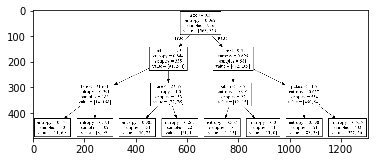

In [53]:
#使用Decision Tree分類器

#建立Decision Tree分類器
tree=DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=0)
tree.fit(train_x,train_y)

#預測測試資料
DecisionTreeResult=pd.DataFrame(tree.predict(test_x))
DecisionTreeResult.columns=['survived']
DecisionTreeResult.to_csv("DecisionTreeResult.csv", encoding='utf_8_sig')

#此為測試資料的正確解答
OriginalResult=pd.DataFrame(test_y.values.reshape(-1))
OriginalResult.columns=['survived']
OriginalResult.to_csv("OriginalResult.csv", encoding='utf_8_sig')

#輸出Decision Tree圖
export_graphviz(tree,out_file='tree.dot',feature_names=column_list)

#將.dot檔轉換為png檔,並開啟
os.environ["PATH"] += os.pathsep + 'D://Graphviz2.38/bin/'
s=Source.from_file('tree.dot',format="png")
img = mpimg.imread('tree.dot.png')
plt.imshow(img)
plt.show()

In [54]:
tree.feature_importances_

array([0.2247905 , 0.59449224, 0.04272083, 0.0655803 , 0.        ,
       0.07241612])

In [55]:
#準確度

#讀檔案
MyResult=pd.read_csv("MyResult.csv")
DecisionTreeResult=pd.read_csv("DecisionTreeResult.csv")
OriginalResult=pd.read_csv("OriginalResult.csv")
MyResult=MyResult.drop(["Unnamed: 0"], axis=1)
DecisionTreeResult=DecisionTreeResult.drop(["Unnamed: 0"], axis=1)
OriginalResult=OriginalResult.drop(["Unnamed: 0"], axis=1)

#計算有幾個數據正確
MyResultCorrect=0
DecisionTreeResultCorrect=0
for i in range(OriginalResult.shape[0]):
    if MyResult['survived'][i]==OriginalResult['survived'][i]:
        MyResultCorrect=MyResultCorrect+1
    if DecisionTreeResult['survived'][i]==OriginalResult['survived'][i]:
        DecisionTreeResultCorrect=DecisionTreeResultCorrect+1
        
#計算準確度
MyResultAcc=(MyResultCorrect/OriginalResult.shape[0])*100
DecisionTreeResultAcc=(DecisionTreeResultCorrect/OriginalResult.shape[0])*100

print('My Result Accuracy: '+str(MyResultAcc)+' %')
print('Decision Tree Result Accuracy: '+str(DecisionTreeResultAcc)+' %')


My Result Accuracy: 34.605597964376585 %
Decision Tree Result Accuracy: 81.1704834605598 %
